In [2]:
# Last time we looked at building a multi-layer perceptron (MLP) following bengio et al to create a name generator. This time, we are going to move forward in history to the next significant step
# by using Recurrent Neural Networks (RNN) and Gated Recursive Convolutional Neural Networks (GRU).
# To really understand these new models, we are going to first dive deeper into MLPs to understand their gradients and back-propagations. This will help us understand why the new approaches
# are hard to optimize, and what we can do about it.

# The first 10 or so code entries in this notebook are clean-up versions of the old MLP code we wrote in the last study.

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [3]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [6]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80% training split
Xdev, Ydev = build_dataset(words[n1:n2])   # 10% dev split
Xte,  Yte  = build_dataset(words[n2:])     # 10% test split

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [35]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size)**0.5) # The multiplications are meant to initialize correctly by scaling the std dev
#b1 = torch.randn(n_hidden,                        generator=g) * 0.01 #trying to get an even distribution, but letting in a little entropy
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 #Don't make this 0, but make it small. Gives us a more even distribution to get rid of the hockey stick effect
b2 = torch.randn(vocab_size,                      generator=g) * 0 #The first loss from the feed forward is way too high. We need a more even distribution at the start. Don't add bias

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

# It turns out that due to new inventions, we aren't really affected by poor initializations. One of those inventions is batch normalizations. We will get to this later.
# Ok now is later =) Batch normalization exists to solve the problem outlined in the matplotlib image a few lines below. Neurons that are on the tail end of the tanh function won't learn.
# Optimally, we want a gaussian distribution with a mean of 0 and a std dev of 1. The idea of batch normalization is that you can just initialize your set to be gaussian =) Of course,
# during training, we don't want to hold this distribution, but rather let the backpropagation tell us what is best. To allow this, we create to new parameters bngain and bnbias, and call
# backwards after every feed forward.

# The weird part about this is that we used to deterministically optimize an input value by feeding forward and passing back. For efficiency, we split the gradient descent into batches,
# with the idea being we can approximate the gradient over a subset of the neurons to a good enough degree. Now all of the sudden, the optimization is a function of the input, but also
# the other neurons that happen to come for a ride in the batch =) Better yet, the batches are randomized =) This means your hidden layer values (and logits) will have some 'jiggle' 
# in them, because the mean and std dev statistics will change depending on what is in the batch. As it turns out, this is a good thing. Think of it as a regularizer. It dampens the
# examples. The jiggle makes it hard for the model to overfit the data because of the noise.

# No one really likes the fact that these variables are coupled to the forward pass. There are a few alternatives that we will explore later.

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [72]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
  # Batchnorm layer
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias # This is batch normalization
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001  * bnstdi
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  #break

      0/ 200000: 3.3014
  10000/ 200000: 2.4789
  20000/ 200000: 2.3364
  30000/ 200000: 2.1072
  40000/ 200000: 2.0523
  50000/ 200000: 2.4329
  60000/ 200000: 2.2905
  70000/ 200000: 2.0826
  80000/ 200000: 2.0123
  90000/ 200000: 2.0183
 100000/ 200000: 2.4473
 110000/ 200000: 2.0486
 120000/ 200000: 2.1925
 130000/ 200000: 2.3583
 140000/ 200000: 2.2693
 150000/ 200000: 2.3672
 160000/ 200000: 2.0888
 170000/ 200000: 2.0872
 180000/ 200000: 2.4111
 190000/ 200000: 1.8808


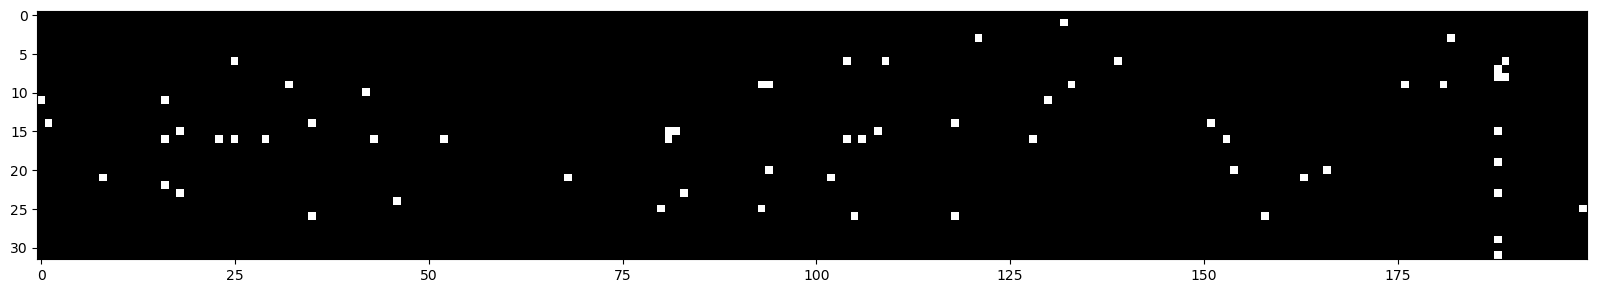

In [53]:
# Something that really hinders our neurons ability to learn is bad initializations. Our activation function is tanh, which has 2 tails at either end. If most of our neuron values are on 
# the tails, the backprop tends to either 0 or 1, since the local gradient is 1-t**2. This means the gradient either goes to 0, or just pushes through without much change (1). Both of these 
# hinder our ability to learn since our gradients only change a small little bit, so we don't make any progress in reducing the loss. This means we essentially have 'dead' neurons =(

# This plot shows white pixels for h values on the tails. There is a batch size of 32 examples, showing the 200 hidden layer neurons. If a column is fully white, the neuron values are staying
# on the tails over all the examples. This would be a dead neuron.

plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

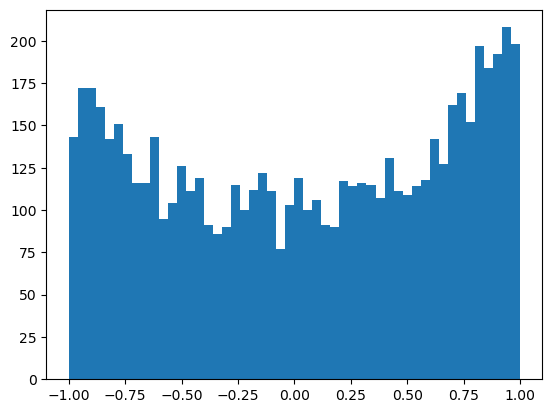

In [54]:
# This shows the tanh values. If it is heavily skewed on the tails, start sweating.

plt.hist(h.view(-1).tolist(), 50);

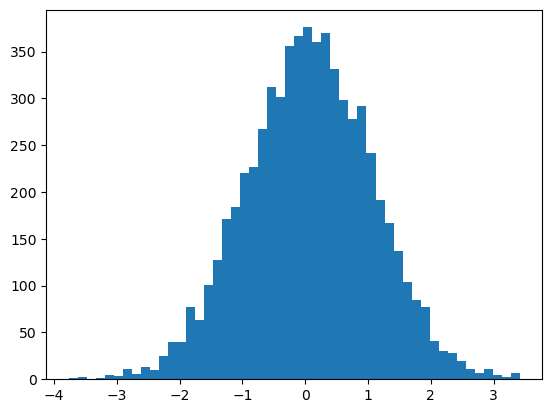

In [55]:
# This is the hidden layer before its fed into the activation function tanh.

plt.hist(hpreact.view(-1).tolist(), 50);

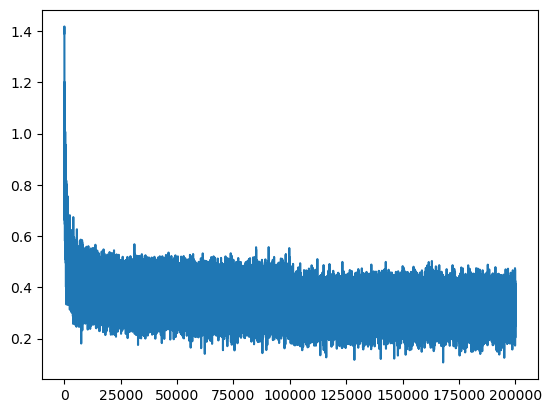

In [33]:
plt.plot(lossi)

In [73]:
# Ok great, we added batch normalization, but now our neural net expects to be fed batches, not single inputs, because we need a mean and std dev. To get around this, we can 'calibrate'
# the statistics. At the end of training, we can get the mean and std dev over the enitre training set and set them as fixed values. Then, when we input a value, we don't need to estimate
# from a batch, but use these calibrated values instead.

# One optimization for this is by calculating during training, instead of doing it after in a 2nd stage. Just keep a running value of the mean and std during training that updates on the side.

with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # measure the mean / std dev over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)


In [76]:
@torch.no_grad() # this decorator disables gradient tracking. This tells Pytorch "Im not going to call for the gradient data, so don't bother tracking it." Efficiency =)
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.065549612045288
val 2.111138343811035


In [75]:
# sample the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size

    while True:
        #forward pass
        emb = C[torch.tensor([context])] # (1, block_size, n_embd)
        h = torch.tanh(emb.view(1,-1) @ W1 + b1) # note the correct broadcasting with adding b1
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)

        #sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()

        #shift the context window and track samples
        context = context[1:] + [ix]
        out.append(ix)

        #if we sample the '.' character, this is the end, so break
        if ix == 0:
            break
    print(''.join(itos[i] for i in out)) #decode and print the generated word

brikammyah.
szelmarulyah.
trishstbrdrlizanderydgrlillevidreardie.
sustinanselyziohmarlin.
shdbnzixhimzyss.
judrifelloxstwrofinncencenriyah.
fzehs.
kayjahstly.
sahmansabylisuffzajmyernnentlucslsgeaislennysx.
fsrishofsydpsisssacurawh.
hmrerlbislairlendrk.
whldariftarshbinneghnnahslicelkx.
brsweld.
treyrsetnnnlysxavonnikellannickarishand.
titza.
jhzvirlquhanserassmiarrylitavidhustvontel.
jhnnyskspph.
ffinzliannchidhbrykelsjsinclendru.
jess.
frandighnlexidhn.


In [29]:
# Nice work! We have done a good job of understanding the fundamentals of batchnorms, but our code is re-inventing the Pytorch wheel. Let's Pytorch-ify our code to make it more legit.

# The Linear class acts as a linear layer in the neural net, just like our hidden layer h for example. It does the matrix multiplication of W @ x. It initializes with weights (and biases 
# if you want them). 

# The BatchNorm1d class act as a batch norm operation: https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html The epsilon only exists for the weird times where the variance is
# 0, to avoid dividing by 0. Remember, the point of batch normalization is to control your activation statistics. Your network can learn much better when the pre-activation linear layers
# are gaussian. These gaussian distributions feed into the activation layer (tanh for us), and comes out without a ton of values on the tail ends. This means your gradients will be more
# 'meaningful', and the neurons can learn by actually decending down the gradient. 

# The Tanh class acts as a tanh layer =)

class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in **0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x): #W @ x
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    

class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        #parameters (trained with backpropagation)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        #buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        #calculate forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance. This is the heart of batch norm.
        self.out = self.gamma * xhat + self.beta # add the parameters

        # update buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self,x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []
      
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size), BatchNorm1d(vocab_size), 
]
# Look how easy this is!!! Because we now have classes, or modules, for each layer, we can just stack them up to build our MLP! This example has 6 layers, with each input going through
# the linear-batchnorm-tanh cycle 6 times!

with torch.no_grad():
    # make the last layer less confident
    layers[-1].gamma *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3 # This is necessary as a counter-force to the tanh squishing. Without this gain, the std dev would tend to 0. This acts as a distribution stretcher, the tanh
            # is a squisher. Together, they live together in harmony =)

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # total number of parameters
for p in parameters:
    p.requires_grad = True

47551


In [30]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers: # I looooooooove that this is just applying the layers serially 
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad()
  for p in parameters:
    p.grad = None
  loss.backward() 
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break

      0/ 200000: 3.2870


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.62%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.47%
layer 8 (      Tanh): mean -0.00, std 0.64, saturated: 2.16%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 1.81%
layer 14 (      Tanh): mean -0.00, std 0.65, saturated: 1.78%


Text(0.5, 1.0, 'activation distribution')

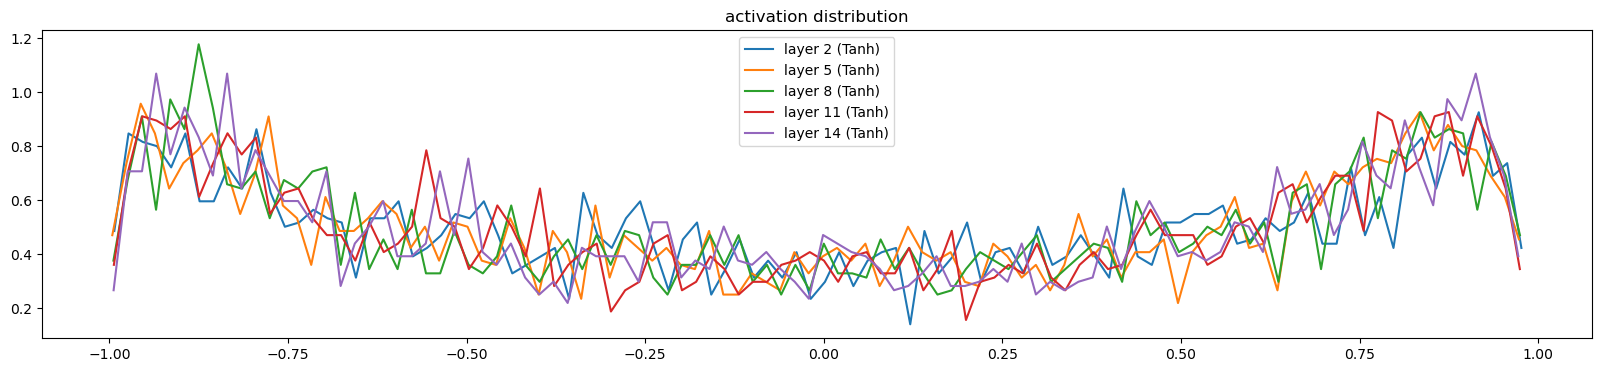

In [31]:
# This graph shows the 'activation distribution'. Think of this as the distribution of all the neuron values in each Tanh layer. The range from -1 to 1. We call a neuron saturated
# if the absolute value is greater than 0.97, meaning it is on the far ends of the tails of the Tanh function. Remember, this is not desirable since it leads to poor gradients. 

# Good result: Mean centered on 0, std around 0.65, saturation lower than 10% (and lower than 4% is even better)
# Bad result: Mean shifted off 0, high std, high saturation

# This gets much easier with batchnorm, since the distribution is modified to be gaussian normal after each linear layer, right before these tanh layers.

# Visualize histograms
plt.figure(figsize=(20,4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.000000, std 3.682954e-03
layer 5 (      Tanh): mean -0.000000, std 3.262609e-03
layer 8 (      Tanh): mean -0.000000, std 2.973730e-03
layer 11 (      Tanh): mean +0.000000, std 2.741110e-03
layer 14 (      Tanh): mean +0.000000, std 2.584293e-03


Text(0.5, 1.0, 'gradient distribution')

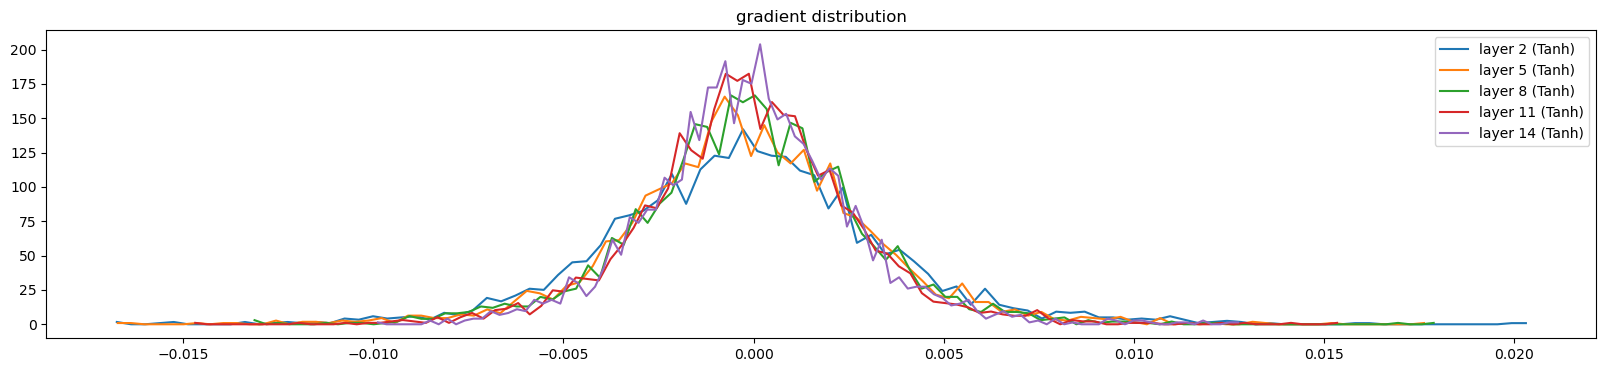

In [32]:
# This graph shows the distribution of gradient values in the same layers from the graph above (the Tanh layers). What we are looking for here is that all the layers have roughly the 
# same distribution. We don't want particular layers to be shrinking or exploding. The exact distribution mean or std isn't as relevant.

# Without batchnorm, tuning this is like balancing a pencil on your finger. With batch norm, the gain you select is much much less sensitive

# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 1.019885e-02 | grad:data ratio 1.018846e-02
weight  (30, 100) | mean +0.000092 | std 8.238431e-03 | grad:data ratio 2.635839e-02
weight (100, 100) | mean +0.000031 | std 7.318113e-03 | grad:data ratio 4.377145e-02
weight (100, 100) | mean -0.000019 | std 6.662024e-03 | grad:data ratio 3.949896e-02
weight (100, 100) | mean -0.000019 | std 5.821515e-03 | grad:data ratio 3.468160e-02
weight (100, 100) | mean +0.000053 | std 5.445295e-03 | grad:data ratio 3.243366e-02
weight  (100, 27) | mean -0.000165 | std 1.046844e-02 | grad:data ratio 6.281263e-02


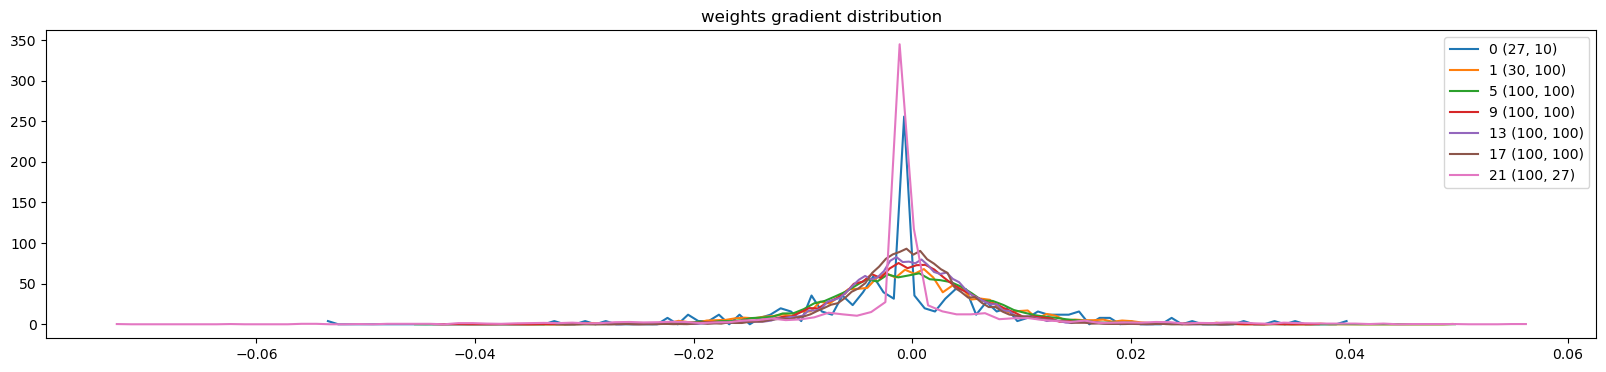

In [33]:
# This shows the gradient/data ratio for each layer over all the neurons. Its a feel of how quickly we are running down the gradient compared to the actual value itself.

# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

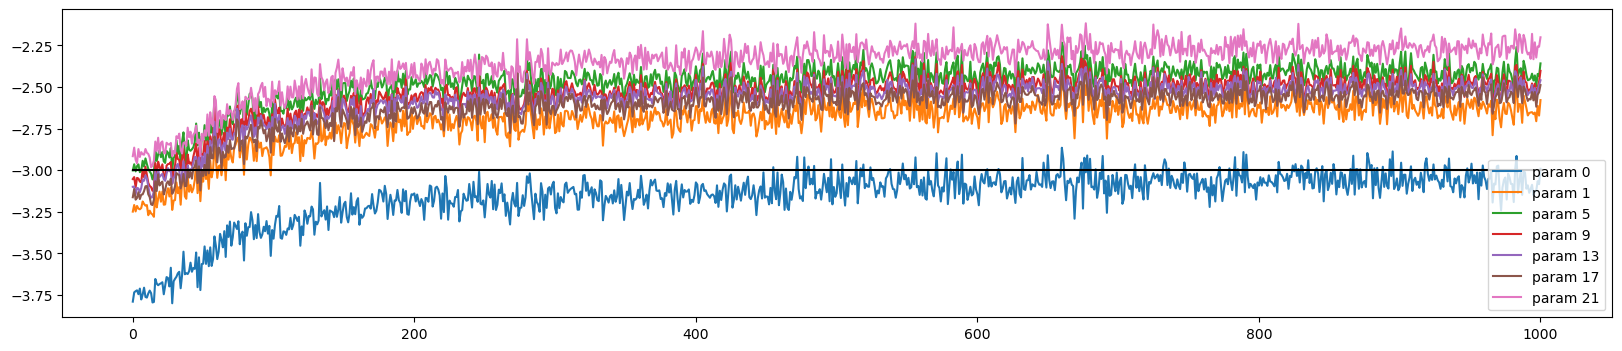

In [34]:
# Here we take the last plot one step further and look at the update rate, not just the gradient. This includes our learning rate scale to the gradient.
# This plot shows the ratio of the update rate to the actual value of the parameter. As lord karpathy states, a healthy ratio is around 1e-3, meaning the change to the parameter is 1000x
# smaller than the actual value of the parameter itself. For example, a value of 1000 would change by 1 every update. 

# Even with batchnorm, our gain selection will still affect these values. Makes sense, since the gain directly scales the denominator.

plt.figure(figsize=(20,4))
legends = []
for i,p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3,-3], 'k') # these ratios should be ~1e-3, indicated on the plot
plt.legend(legends);